In [1]:
import tensorflow as tf
import pandas as pd
import multiprocessing
import concurrent.futures
from PIL import Image
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from keras.applications import DenseNet201
from keras.models import Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
def load_data(x_df_path, y_df_path):
    x_df = pd.read_csv(x_df_path)
    y_df = pd.read_csv(y_df_path)
    x_paths = x_df.iloc[:, 0:1]
    x_meta = x_df.iloc[:,2:].values
    y = y_df.iloc[:,:].values
    return x_meta, y

In [3]:
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TFormer(tf.keras.Model):
    def __init__(self, embed_dim=128, num_heads=8, ff_dim=128, num_transformer_blocks=6, mlp_units=128, dropout=0.1, mlp_dropout=0.1):
        super(TFormer, self).__init__()

        self.embedding = tf.keras.layers.Embedding(input_dim=17, output_dim=embed_dim)
        self.positional_encoding = PositionalEncoding(17, embed_dim)

        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_transformer_blocks)]

        self.flatten = tf.keras.layers.Flatten()
        self.mlp = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(mlp_units, activation=tf.nn.gelu),
                tf.keras.layers.Dropout(mlp_dropout),
                tf.keras.layers.Dense(2, activation="sigmoid"),
            ]
        )

    def call(self, inputs):
        x = self.embedding(inputs)
        x += self.positional_encoding(x)
        
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        
        x = self.flatten(x)
        return self.mlp(x)

In [4]:
def convert_numpy_to_tensor(X_train):
    X_train_tensor = tf.convert_to_tensor(X_train)
    return X_train_tensor

In [5]:
X_train, y_train = load_data('X_train_df.csv', 'y_train_df.csv')
X_val, y_val = load_data('X_val_df.csv', 'y_val_df.csv')
X_test, y_test = load_data('X_test_df.csv', 'y_test_df.csv')

In [6]:
X_train.shape

(8460, 17)

In [7]:
X_train = convert_numpy_to_tensor(X_train[:,:])
y_train = convert_numpy_to_tensor(y_train)
X_val = convert_numpy_to_tensor(X_val[:,:])
y_val = convert_numpy_to_tensor(y_val)
X_test = convert_numpy_to_tensor(X_test[:,:])
y_test = convert_numpy_to_tensor(y_test)

In [8]:
model = TFormer()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [9]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_val, y_val),
)

Epoch 1/10
265/265 [==============================] - 17s 46ms/step - loss: 0.2181 - accuracy: 0.9429 - val_loss: 0.0507 - val_accuracy: 1.0000
Epoch 2/10
265/265 [==============================] - 12s 45ms/step - loss: 0.0066 - accuracy: 0.9991 - val_loss: 2.1772e-04 - val_accuracy: 1.0000
Epoch 3/10
265/265 [==============================] - 12s 45ms/step - loss: 4.8160e-04 - accuracy: 1.0000 - val_loss: 7.8035e-05 - val_accuracy: 1.0000
Epoch 4/10
265/265 [==============================] - 12s 45ms/step - loss: 2.1920e-04 - accuracy: 1.0000 - val_loss: 4.2520e-05 - val_accuracy: 1.0000
Epoch 5/10
265/265 [==============================] - 12s 44ms/step - loss: 1.3690e-04 - accuracy: 1.0000 - val_loss: 2.5421e-05 - val_accuracy: 1.0000
Epoch 6/10
265/265 [==============================] - 12s 45ms/step - loss: 8.6434e-05 - accuracy: 1.0000 - val_loss: 1.7179e-05 - val_accuracy: 1.0000
Epoch 7/10
265/265 [==============================] - 12s 45ms/step - loss: 6.2099e-05 - accuracy: 1

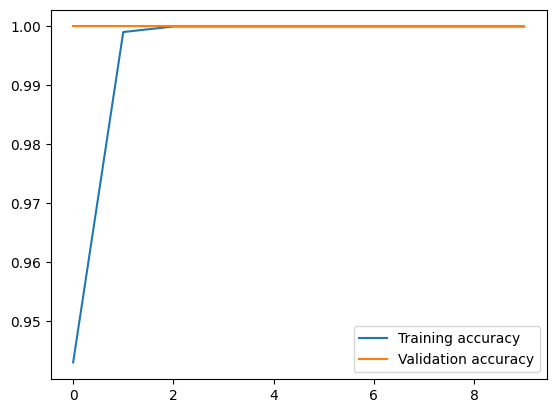

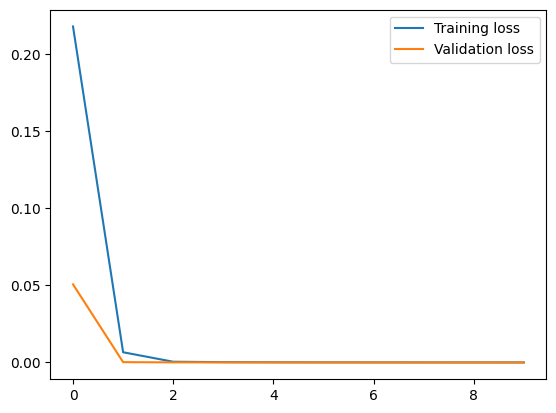

In [10]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [11]:
evaluation_result = model.evaluate(X_test, y_test)

print("Métricas de evaluación:")
print("Loss:", evaluation_result[0])
print("Precisión (Accuracy):", evaluation_result[1])

34/34 [==============================] - 1s 17ms/step - loss: 7.2234e-06 - accuracy: 1.0000
Métricas de evaluación:
Loss: 7.223380180221284e-06
Precisión (Accuracy): 1.0


In [12]:
def plot_confusion_matrix(y_true, y_pred, diseases, cmap=plt.cm.Blues):
    ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true, cmap=cmap)
    plt.xticks(np.arange(len(diseases)), diseases, rotation=45)
    plt.yticks(np.arange(len(diseases)), diseases)
    plt.grid(False)
    plt.show()

def plot_normalized_confusion_matrix(y_true, y_pred, diseases):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm_normalized, index=diseases, columns=diseases)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt=".2f", cbar=True)
    plt.xticks(np.arange(len(diseases)) + 0.5, diseases, rotation=45)
    plt.yticks(np.arange(len(diseases)) + 0.5, diseases, rotation=0)
    plt.gca().set_facecolor('lightgray')
    plt.gca().add_patch(plt.Rectangle((0, 0), len(diseases), len(diseases), fill=False, edgecolor='black', lw=2))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_classification_report(y_true, y_pred, diseases):
    print(classification_report(y_pred=y_pred, y_true=y_true, target_names=diseases))

def print_multiclass_cm_metrics(y_true, y_pred, diseases, printable = False, plottable=True):
    mcm = multilabel_confusion_matrix(y_true=y_true, y_pred=y_pred)
    accuracy = []
    sensitivity = []
    specificity = []
    precision = []
    
    for i in range(len(mcm)):
        tp = mcm[i][1,1]
        tn = mcm[i][0,0]
        fp = mcm[i][0,1]
        fn = mcm[i][1,0]
        current_accuracy = (tp+tn)/(tp+tn+fp+fn)
        current_sensitivity = (tp)/(tp+fn)
        current_specificity = (tn)/(tn+fp)
        current_precision = (tp)/(tp+fp)
        if printable:
            print(f"\tPrecision: {current_precision}")
            print(f"\tSensitivity: {current_sensitivity}")
            print(f"\tSpecificity: {current_specificity}")
            print(f"\tAccuracy: {current_accuracy}")
            print()
        accuracy.append(current_accuracy)
        precision.append(current_precision)
        sensitivity.append(current_sensitivity)
        specificity.append(current_specificity)
    
    width = 0.3
    x = np.arange(len(diseases))
    font_size=6
    if plottable:
        plt.bar(x-width,precision, width = width, label='Precision')
        plt.bar(x, accuracy, width=width, label='Accuracy')
        plt.bar(x+width, sensitivity, width=width, label='Sensitivity')
        for x1, x2, x3, y1, y2, y3 in zip(x-width, x, x+width, precision, accuracy, sensitivity):
            plt.text(x1, y1, '%.2f' % y1, ha='center', va='bottom', fontsize=font_size)
            plt.text(x2, y2, '%.2f' % y2, ha='center', va='bottom', fontsize=font_size)
            plt.text(x3, y3, '%.2f' % y3, ha='center', va='bottom', fontsize=font_size)
        plt.xticks(x, diseases)
        plt.legend(loc='lower left')
        plt.show()

def get_metrics(x_test, y_test, model):
    diseases = ['Malignant', 'Benign']
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true =  np.argmax(y_test, axis=1)
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred, diseases=diseases)
    plot_normalized_confusion_matrix(y_true=y_true, y_pred=y_pred, diseases=diseases)
    plot_classification_report(y_pred=y_pred, y_true=y_true, diseases=diseases)
    print_multiclass_cm_metrics(y_true=y_true, y_pred=y_pred, diseases=diseases)

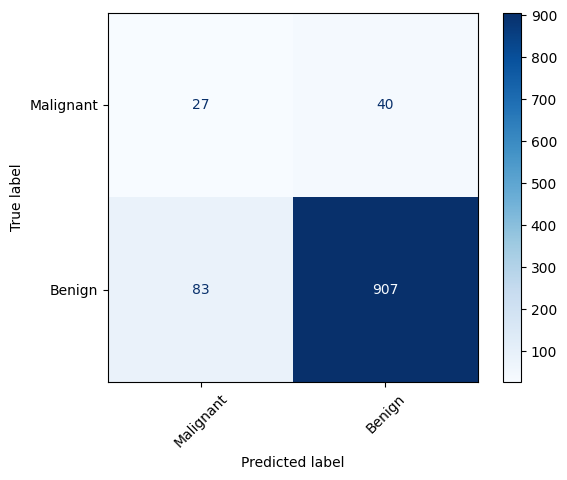

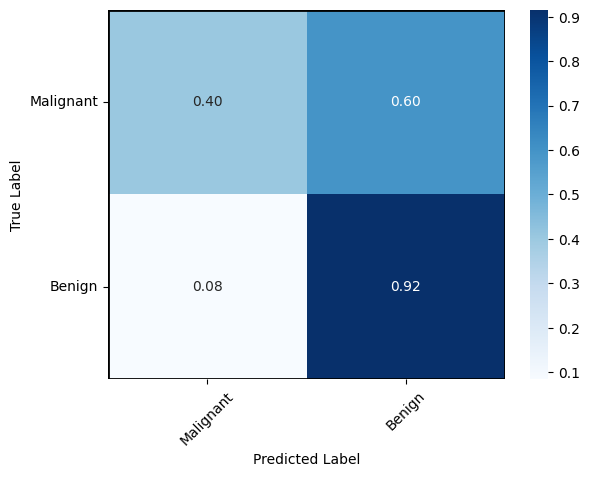

              precision    recall  f1-score   support

   Malignant       0.25      0.40      0.31        67
      Benign       0.96      0.92      0.94       990

    accuracy                           0.88      1057
   macro avg       0.60      0.66      0.62      1057
weighted avg       0.91      0.88      0.90      1057



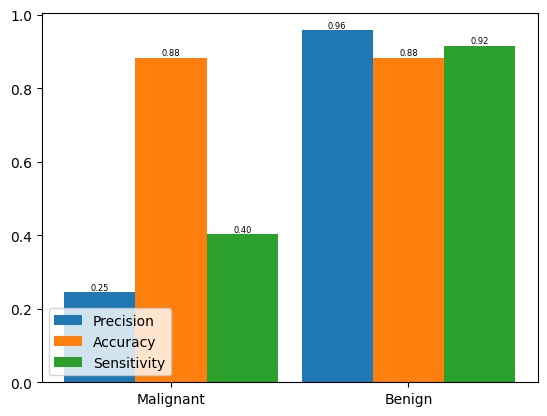

In [1]:
get_metrics(X_test, y_test, model)

In [14]:
model.save_weights("tformer_model_weights.h5")